# 🏠 Analiza Transakcji Nieruchomości - Kraków 2023-2025

Agregacja cen i liczby transakcji wg **111 jednostek urbanistycznych**.

**Czyszczenie danych:**
- ❌ Cena < 6000 zł/m² (błędy, mieszkania komunalne)
- ❌ Jednostki < 10 transakcji w 3 lata (niewiarygodne)

---

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import warnings
warnings.filterwarnings('ignore')

# Konfiguracja
CRS_METRIC = "EPSG:2180"
MIN_PRICE_M2 = 6000  # Minimalna cena zł/m²
MIN_TRANSACTIONS = 10  # Minimum transakcji w jednostce (3 lata)

print("✅ Konfiguracja:")
print(f"   Min cena: {MIN_PRICE_M2:,} zł/m²")
print(f"   Min transakcji/jednostkę: {MIN_TRANSACTIONS}")

✅ Konfiguracja:
   Min cena: 6,000 zł/m²
   Min transakcji/jednostkę: 10


## 1. Wczytanie i Czyszczenie Danych

In [2]:
print("📂 Wczytywanie danych transakcji...")

# Wczytaj oba rynki (surowe dane - przed czyszczeniem)
gdf_pierwotny = gpd.read_file('data/raw/transactions_pierwotny_2023_2025_raw.geojson')
gdf_wtorny = gpd.read_file('data/raw/transactions_wtorny_2023_2025_raw.geojson')

print(f"   Rynek pierwotny: {len(gdf_pierwotny):,} rekordów")
print(f"   Rynek wtórny: {len(gdf_wtorny):,} rekordów")

# Dodaj kolumnę rynku
gdf_pierwotny['rynek'] = 'pierwotny'
gdf_wtorny['rynek'] = 'wtorny'

📂 Wczytywanie danych transakcji...
   Rynek pierwotny: 954 rekordów
   Rynek wtórny: 2,196 rekordów


In [3]:
# Połącz dane
gdf_all = pd.concat([gdf_pierwotny, gdf_wtorny], ignore_index=True)
gdf_all = gpd.GeoDataFrame(gdf_all, geometry='geometry', crs=gdf_pierwotny.crs)

print(f"📊 Razem przed czyszczeniem: {len(gdf_all):,} rekordów")

# Sprawdź kolumny
print(f"\nKolumny: {list(gdf_all.columns)[:10]}...")

📊 Razem przed czyszczeniem: 3,150 rekordów

Kolumny: ['objectid', 'data_zaw_year', 'data_zaw_month', 'rodzaj_rynku', 'sr_cena', 'sr_pow', 'sr_cena_m2', 'lkl_count', 'id_ju', 'nazwa_jedn']...


In [4]:
# CZYSZCZENIE 1: Usuń transakcje z ceną < 6000 zł/m²
before = len(gdf_all)
gdf_clean = gdf_all[gdf_all['sr_cena_m2'] >= MIN_PRICE_M2].copy()
removed_price = before - len(gdf_clean)

print(f"🧹 Czyszczenie danych:")
print(f"   ❌ Usunięto {removed_price:,} rekordów (cena < {MIN_PRICE_M2} zł/m²)")
print(f"   ✅ Pozostało: {len(gdf_clean):,} rekordów")

🧹 Czyszczenie danych:
   ❌ Usunięto 5 rekordów (cena < 6000 zł/m²)
   ✅ Pozostało: 3,145 rekordów


In [5]:
# Projekcja do układu metrycznego
gdf_clean = gdf_clean.to_crs(CRS_METRIC)
print(f"✅ Projekcja do {CRS_METRIC}")

✅ Projekcja do EPSG:2180


## 2. Agregacja wg Jednostek Urbanistycznych

In [6]:
# Funkcja agregująca dla danego rynku
def aggregate_by_unit(gdf, rynek_name):
    """Agreguje dane per jednostka dla danego rynku."""
    
    agg = gdf.groupby('nazwa_jedn').agg(
        transakcje=('lkl_count', 'sum'),
        sr_cena_m2=('sr_cena_m2', 'mean'),
        min_cena=('sr_cena_m2', 'min'),
        max_cena=('sr_cena_m2', 'max'),
        geometry=('geometry', 'first')  # Weź pierwszą geometrię
    ).reset_index()
    
    agg['rynek'] = rynek_name
    agg['sr_cena_m2'] = agg['sr_cena_m2'].round(0).astype(int)
    
    return agg

# Agregacja dla każdego rynku
print("📊 Agregacja danych wg jednostek...")

# Pierwotny
agg_pierwotny = aggregate_by_unit(
    gdf_clean[gdf_clean['rynek'] == 'pierwotny'], 
    'pierwotny'
)
print(f"   Pierwotny: {len(agg_pierwotny)} jednostek")

# Wtórny
agg_wtorny = aggregate_by_unit(
    gdf_clean[gdf_clean['rynek'] == 'wtorny'], 
    'wtorny'
)
print(f"   Wtórny: {len(agg_wtorny)} jednostek")

# Razem (oba rynki)
agg_razem = aggregate_by_unit(gdf_clean, 'razem')
print(f"   Razem: {len(agg_razem)} jednostek")

📊 Agregacja danych wg jednostek...
   Pierwotny: 83 jednostek
   Wtórny: 100 jednostek
   Razem: 113 jednostek


In [7]:
# CZYSZCZENIE 2: Usuń jednostki z < 10 transakcji
print(f"\n🧹 Filtrowanie jednostek (min {MIN_TRANSACTIONS} transakcji):")

before_p = len(agg_pierwotny)
agg_pierwotny = agg_pierwotny[agg_pierwotny['transakcje'] >= MIN_TRANSACTIONS]
print(f"   Pierwotny: {before_p} → {len(agg_pierwotny)} jednostek")

before_w = len(agg_wtorny)
agg_wtorny = agg_wtorny[agg_wtorny['transakcje'] >= MIN_TRANSACTIONS]
print(f"   Wtórny: {before_w} → {len(agg_wtorny)} jednostek")

before_r = len(agg_razem)
agg_razem = agg_razem[agg_razem['transakcje'] >= MIN_TRANSACTIONS]
print(f"   Razem: {before_r} → {len(agg_razem)} jednostek")


🧹 Filtrowanie jednostek (min 10 transakcji):
   Pierwotny: 83 → 72 jednostek
   Wtórny: 100 → 94 jednostek
   Razem: 113 → 105 jednostek


In [8]:
# Konwertuj na GeoDataFrame
agg_pierwotny = gpd.GeoDataFrame(agg_pierwotny, geometry='geometry', crs=CRS_METRIC)
agg_wtorny = gpd.GeoDataFrame(agg_wtorny, geometry='geometry', crs=CRS_METRIC)
agg_razem = gpd.GeoDataFrame(agg_razem, geometry='geometry', crs=CRS_METRIC)

print("✅ GeoDataFrames utworzone")

✅ GeoDataFrames utworzone


## 3. Statystyki Ogólne

In [9]:
print("📈 STATYSTYKI CENOWE (po czyszczeniu):")
print("="*60)

for name, df in [('Pierwotny', agg_pierwotny), ('Wtórny', agg_wtorny), ('Razem', agg_razem)]:
    total_trans = df['transakcje'].sum()
    avg_price = df['sr_cena_m2'].mean()
    min_price = df['sr_cena_m2'].min()
    max_price = df['sr_cena_m2'].max()
    
    print(f"\n🏠 {name}:")
    print(f"   Jednostki: {len(df)}")
    print(f"   Transakcje: {total_trans:,}")
    print(f"   Śr. cena: {avg_price:,.0f} zł/m²")
    print(f"   Min: {min_price:,} zł/m² | Max: {max_price:,} zł/m²")

📈 STATYSTYKI CENOWE (po czyszczeniu):

🏠 Pierwotny:
   Jednostki: 72
   Transakcje: 21,070
   Śr. cena: 13,844 zł/m²
   Min: 7,923 zł/m² | Max: 29,973 zł/m²

🏠 Wtórny:
   Jednostki: 94
   Transakcje: 17,578
   Śr. cena: 14,105 zł/m²
   Min: 10,891 zł/m² | Max: 22,784 zł/m²

🏠 Razem:
   Jednostki: 105
   Transakcje: 38,689
   Śr. cena: 13,562 zł/m²
   Min: 8,301 zł/m² | Max: 23,205 zł/m²


In [10]:
# TOP 10 najdroższych jednostek
print("\n🏆 TOP 10 NAJDROŻSZYCH JEDNOSTEK (rynek razem):")
print("="*60)

top10 = agg_razem.nlargest(10, 'sr_cena_m2')[['nazwa_jedn', 'sr_cena_m2', 'transakcje']]
for i, row in enumerate(top10.itertuples(), 1):
    print(f"{i:2}. {row.nazwa_jedn:30} | {row.sr_cena_m2:,} zł/m² | {row.transakcje:,} trans.")

print("\n💰 TOP 10 NAJTAŃSZYCH JEDNOSTEK:")
print("="*60)

bottom10 = agg_razem.nsmallest(10, 'sr_cena_m2')[['nazwa_jedn', 'sr_cena_m2', 'transakcje']]
for i, row in enumerate(bottom10.itertuples(), 1):
    print(f"{i:2}. {row.nazwa_jedn:30} | {row.sr_cena_m2:,} zł/m² | {row.transakcje:,} trans.")


🏆 TOP 10 NAJDROŻSZYCH JEDNOSTEK (rynek razem):
 1. Stradom                        | 23,205 zł/m² | 68 trans.
 2. Stare Miasto                   | 20,223 zł/m² | 57 trans.
 3. Nowy Świat                     | 20,071 zł/m² | 143 trans.
 4. Wesoła Zachód                  | 18,563 zł/m² | 84 trans.
 5. Piasek Południe                | 18,477 zł/m² | 115 trans.
 6. Warszawskie                    | 18,365 zł/m² | 657 trans.
 7. Grzegórzki Zachód              | 17,982 zł/m² | 335 trans.
 8. Grzegórzki Wschód              | 17,584 zł/m² | 860 trans.
 9. Wesoła Wschód                  | 17,582 zł/m² | 45 trans.
10. Zwierzyniec                    | 17,567 zł/m² | 238 trans.

💰 TOP 10 NAJTAŃSZYCH JEDNOSTEK:
 1. Sidzina                        | 8,301 zł/m² | 17 trans.
 2. Olszyny                        | 8,456 zł/m² | 71 trans.
 3. Kostrze                        | 9,439 zł/m² | 20 trans.
 4. Mogiła                         | 9,858 zł/m² | 58 trans.
 5. Grębałów                       | 10,099 zł/m²

## 4. Mapy - Średnia Cena

In [11]:
# Kolorystyka dla cen: zielony (tanie) -> żółty -> czerwony (drogie)
colors_price = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c', '#8e44ad']
cmap_price = LinearSegmentedColormap.from_list('price', colors_price)

# Progi cenowe
price_bounds = [0, 10000, 13000, 16000, 19000, 30000]
norm_price = BoundaryNorm(price_bounds, cmap_price.N)

def create_price_map(gdf, title, filename):
    """Tworzy mapę średnich cen."""
    fig, ax = plt.subplots(figsize=(14, 12))
    
    gdf.plot(
        ax=ax,
        column='sr_cena_m2',
        cmap=cmap_price,
        norm=norm_price,
        edgecolor='white',
        linewidth=0.5,
        legend=True,
        legend_kwds={'label': 'Cena zł/m²', 'shrink': 0.6}
    )
    
    # Statystyki
    stats = (
        f"Jednostki: {len(gdf)}\n"
        f"Transakcje: {gdf['transakcje'].sum():,}\n"
        f"Śr. cena: {gdf['sr_cena_m2'].mean():,.0f} zł/m²"
    )
    ax.text(0.02, 0.98, stats, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Zapisano: {filename}")

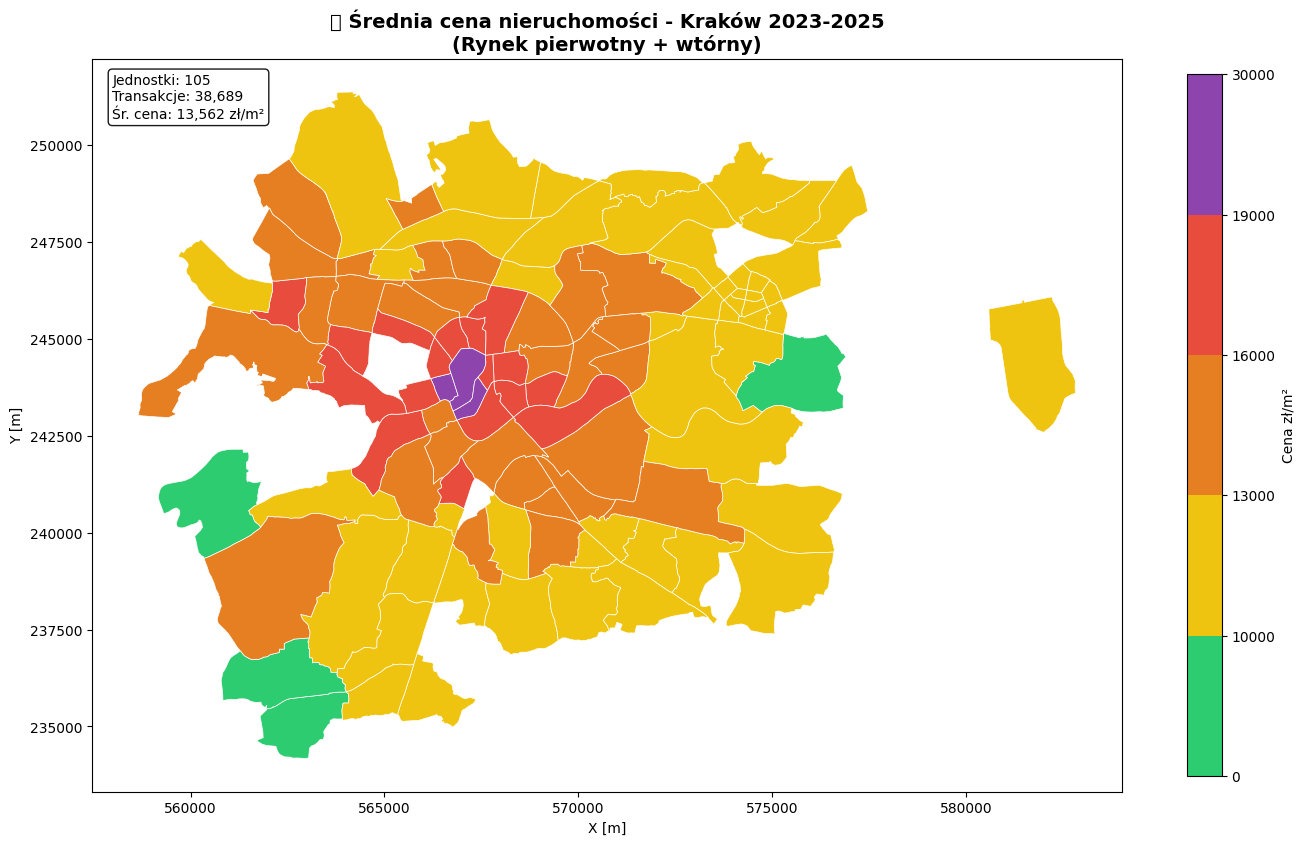

💾 Zapisano: data/mapa_ceny_razem.png


In [12]:
# Mapa cen - RAZEM
create_price_map(
    agg_razem,
    '🏠 Średnia cena nieruchomości - Kraków 2023-2025\n(Rynek pierwotny + wtórny)',
    'data/mapa_ceny_razem.png'
)

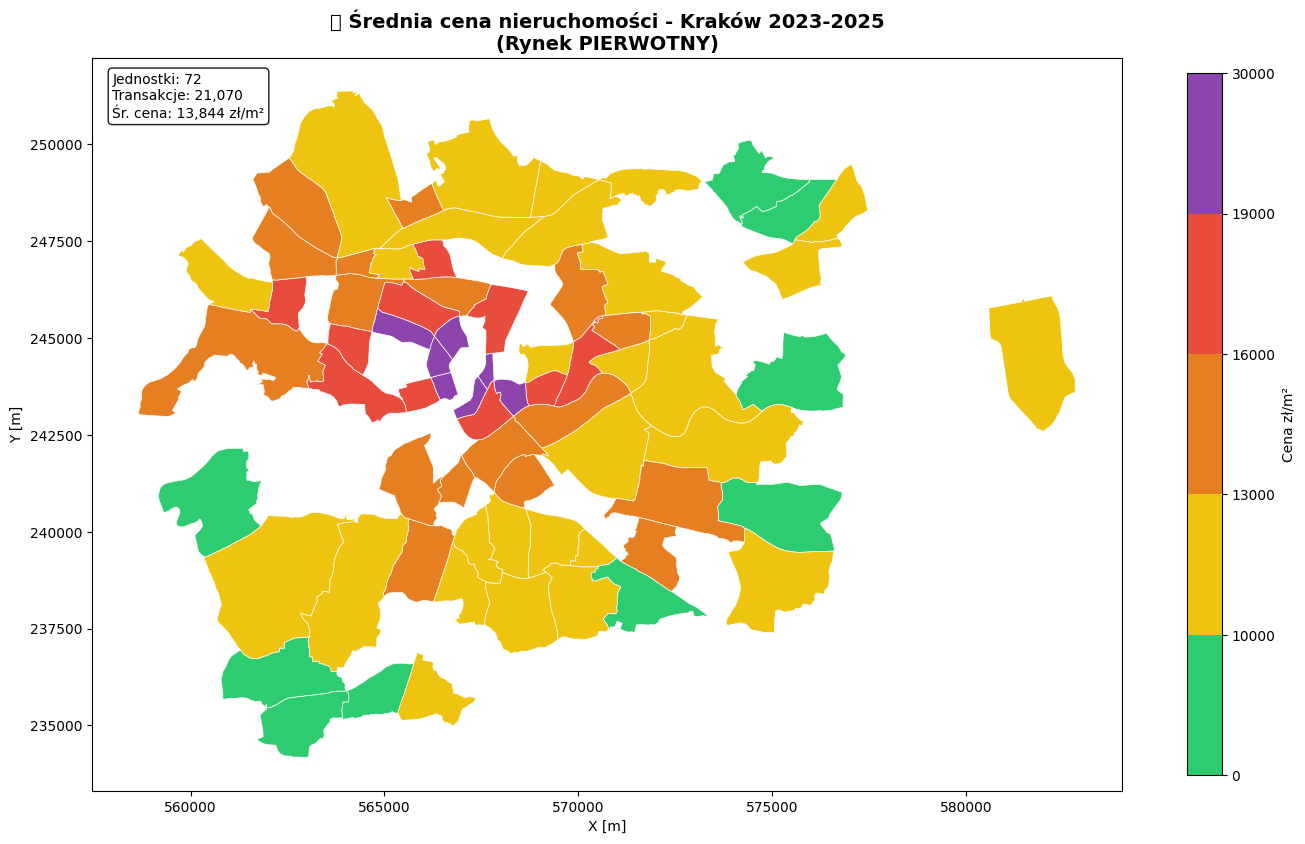

💾 Zapisano: data/mapa_ceny_pierwotny.png


In [13]:
# Mapa cen - PIERWOTNY
create_price_map(
    agg_pierwotny,
    '🏠 Średnia cena nieruchomości - Kraków 2023-2025\n(Rynek PIERWOTNY)',
    'data/mapa_ceny_pierwotny.png'
)

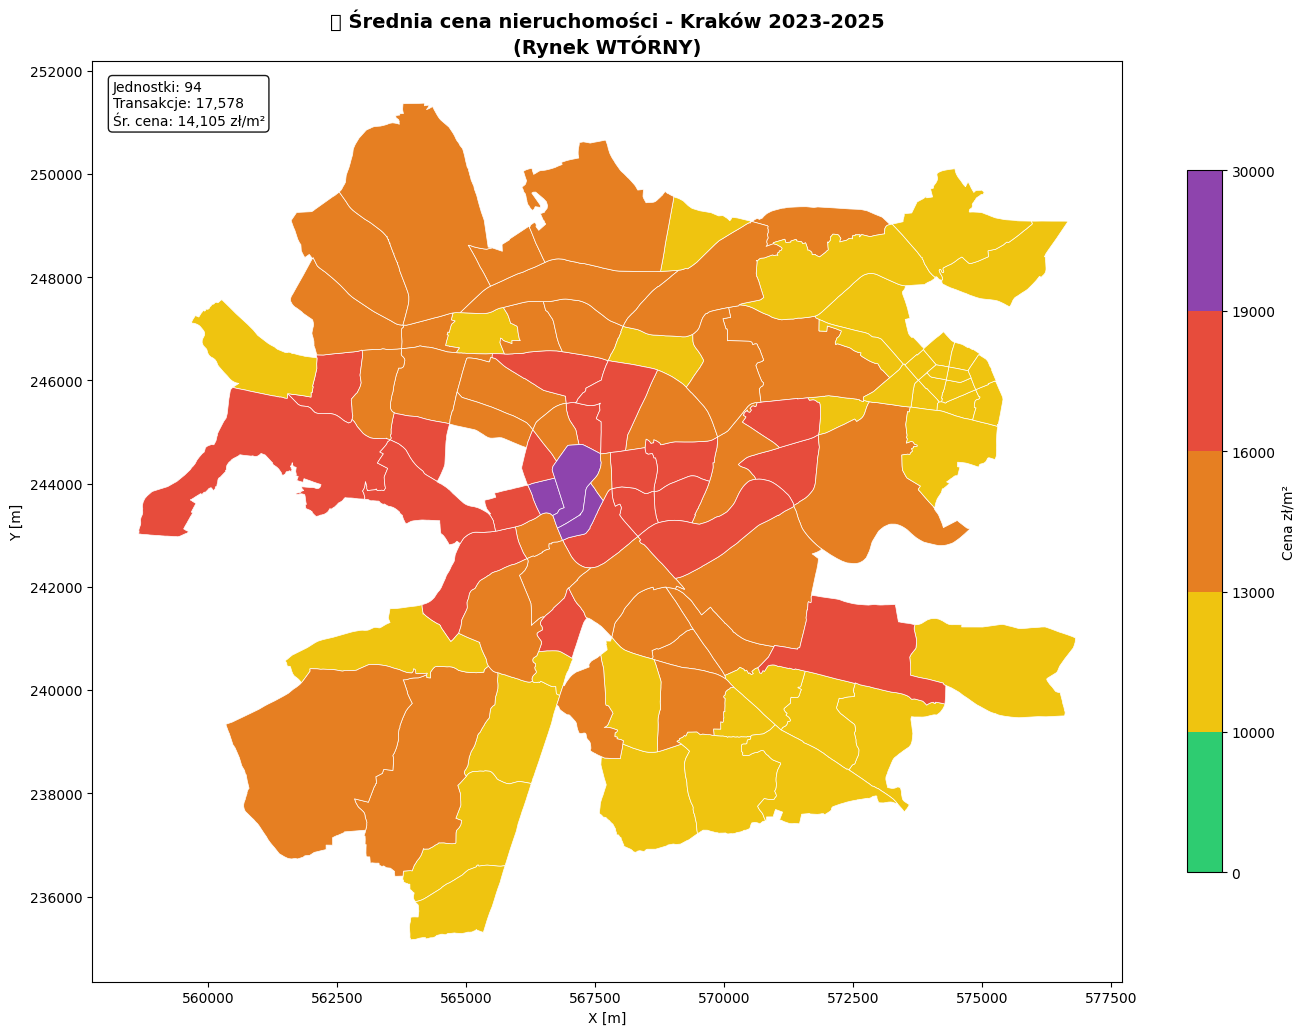

💾 Zapisano: data/mapa_ceny_wtorny.png


In [14]:
# Mapa cen - WTÓRNY
create_price_map(
    agg_wtorny,
    '🏠 Średnia cena nieruchomości - Kraków 2023-2025\n(Rynek WTÓRNY)',
    'data/mapa_ceny_wtorny.png'
)

## 5. Mapy - Liczba Transakcji

In [15]:
# Kolorystyka dla ilości transakcji
colors_trans = ['#3498db', '#9b59b6', '#e67e22', '#e74c3c']
cmap_trans = LinearSegmentedColormap.from_list('trans', colors_trans)

def create_transactions_map(gdf, title, filename):
    """Tworzy mapę liczby transakcji."""
    fig, ax = plt.subplots(figsize=(14, 12))
    
    gdf.plot(
        ax=ax,
        column='transakcje',
        cmap=cmap_trans,
        edgecolor='white',
        linewidth=0.5,
        legend=True,
        legend_kwds={'label': 'Liczba transakcji', 'shrink': 0.6}
    )
    
    stats = (
        f"Jednostki: {len(gdf)}\n"
        f"Razem transakcji: {gdf['transakcje'].sum():,}"
    )
    ax.text(0.02, 0.98, stats, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"💾 Zapisano: {filename}")

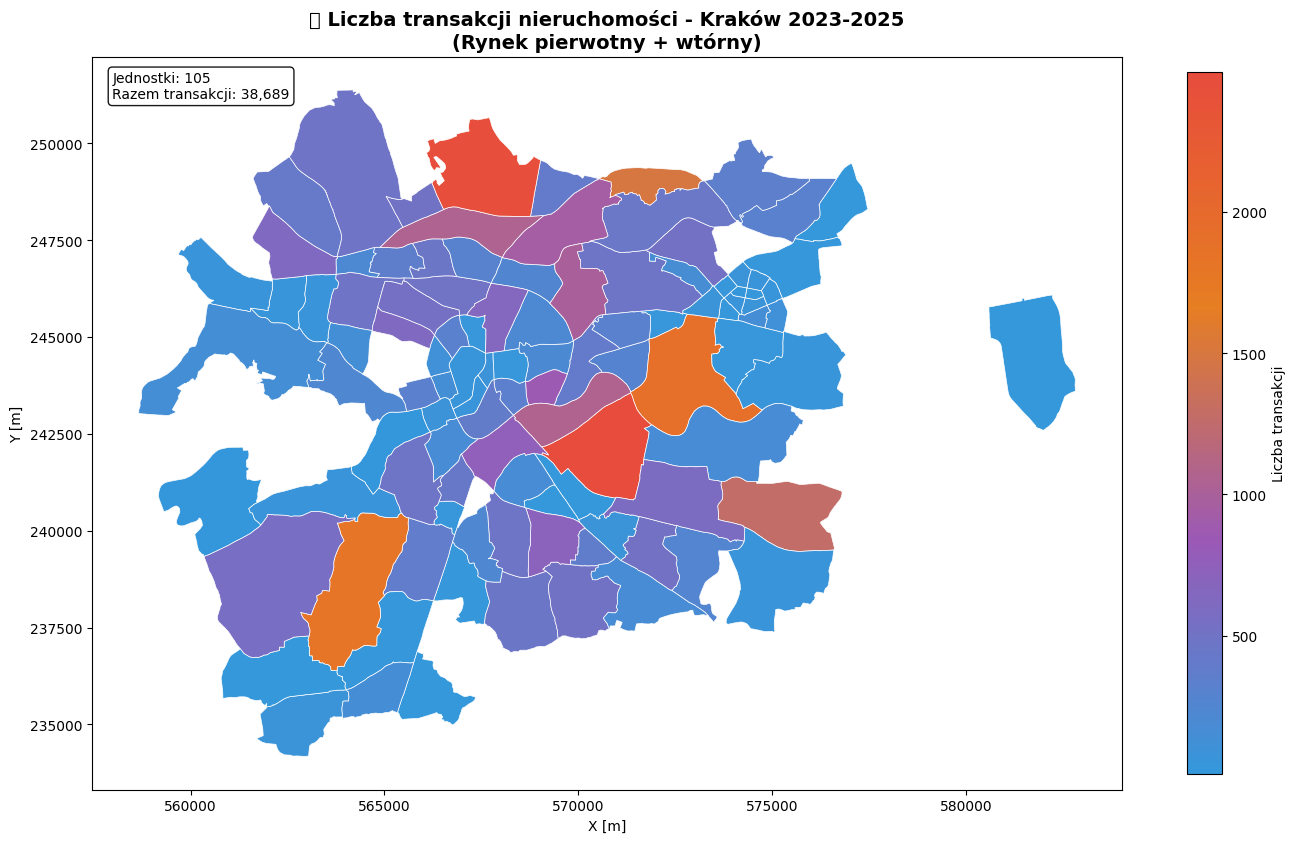

💾 Zapisano: data/mapa_transakcje_razem.png


In [16]:
# Mapa transakcji - RAZEM
create_transactions_map(
    agg_razem,
    '📊 Liczba transakcji nieruchomości - Kraków 2023-2025\n(Rynek pierwotny + wtórny)',
    'data/mapa_transakcje_razem.png'
)

## 6. Porównanie Rynków

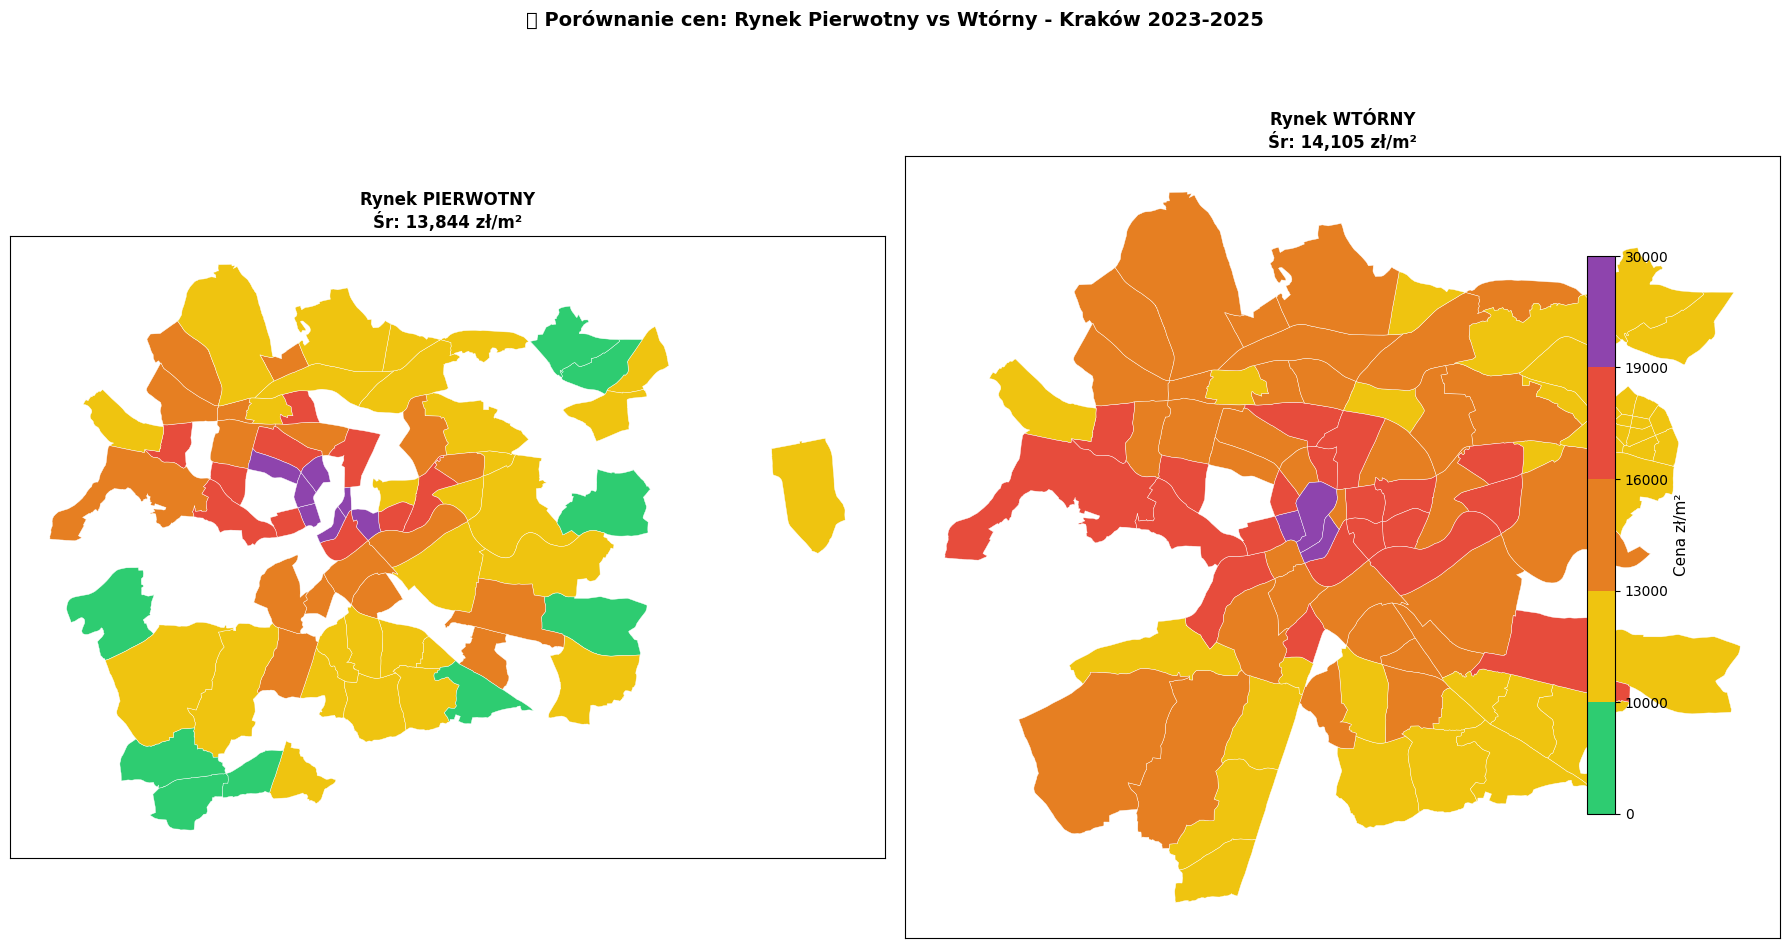

💾 Zapisano: data/mapa_porownanie_rynkow.png


In [17]:
# Porównanie cen pierwotny vs wtórny
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

for ax, gdf, title in [
    (axes[0], agg_pierwotny, 'Rynek PIERWOTNY'),
    (axes[1], agg_wtorny, 'Rynek WTÓRNY')
]:
    gdf.plot(
        ax=ax,
        column='sr_cena_m2',
        cmap=cmap_price,
        norm=norm_price,
        edgecolor='white',
        linewidth=0.3
    )
    
    avg = gdf['sr_cena_m2'].mean()
    ax.set_title(f'{title}\nŚr: {avg:,.0f} zł/m²', fontsize=12, fontweight='bold')
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

# Wspólny colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_price, norm=norm_price)
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Cena zł/m²', fontsize=11)

fig.suptitle('🏠 Porównanie cen: Rynek Pierwotny vs Wtórny - Kraków 2023-2025', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('data/mapa_porownanie_rynkow.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Zapisano: data/mapa_porownanie_rynkow.png")

## 7. Eksport Danych

In [18]:
# Eksport do GeoPackage
agg_razem.to_crs('EPSG:4326').to_file('data/transakcje_jednostki.gpkg', driver='GPKG', layer='razem')
agg_pierwotny.to_crs('EPSG:4326').to_file('data/transakcje_jednostki.gpkg', driver='GPKG', layer='pierwotny')
agg_wtorny.to_crs('EPSG:4326').to_file('data/transakcje_jednostki.gpkg', driver='GPKG', layer='wtorny')
print("💾 GeoPackage: data/transakcje_jednostki.gpkg")

# Eksport do CSV
csv_razem = agg_razem.drop(columns=['geometry']).sort_values('sr_cena_m2', ascending=False)
csv_razem.to_csv('data/transakcje_ranking_cen.csv', index=False, encoding='utf-8-sig')
print("💾 CSV: data/transakcje_ranking_cen.csv")

print("\n✅ ANALIZA ZAKOŃCZONA!")

💾 GeoPackage: data/transakcje_jednostki.gpkg
💾 CSV: data/transakcje_ranking_cen.csv

✅ ANALIZA ZAKOŃCZONA!
